In [1]:


import os

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models,transforms, datasets

import torch.optim as optim
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torch.optim import lr_scheduler

In [2]:

import torch

# Global checkpoint path and best validation acc across folds
CKPT_PATH = r"D:\Ezz\Graduation Project\FinetunedModel2_checkpoint.pth"
best_val_acc_glob = 0.0


In [3]:
dataset_dir = 'D:\Ezz\Graduation Project\Final Handwriting\Character_2output\Dataset Dyslexia_Hand'
num_classes = 2
image_shape = (224, 224)

In [4]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=self.natural_key)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def natural_key(self, string_):
        try:
            return int(string_)
        except ValueError:
            return string_

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        try:
            image = Image.open(image_path).convert("RGB")
        except (OSError, IOError) as e:
            print(f"Skipping corrupted image: {image_path}, Error: {e}")
            # Return a zero tensor and a dummy label in case of error
            image = Image.new('RGB', (224, 224))  # Assuming the image size to be 224x224
            label = -1  # You might want to handle this label properly later

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.ToTensor(),
])

In [6]:
dataset = MakeDataset(dataset_dir, transform=transform)

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
batch_size = 16

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Data Samples

Training Samples:


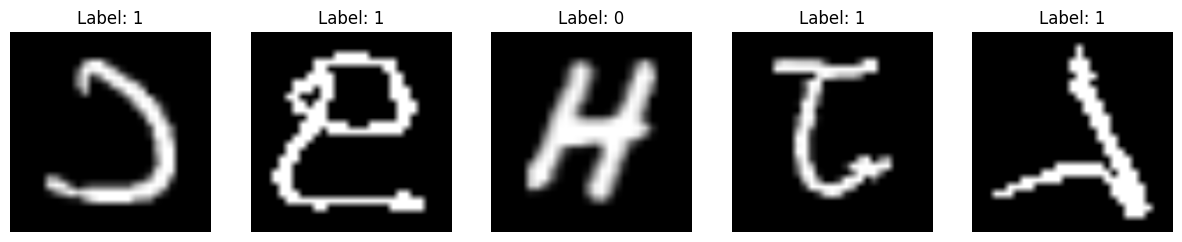

Validation Samples:


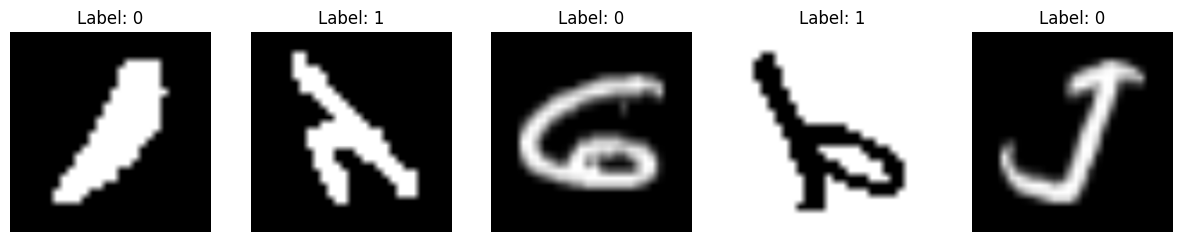

Testing Samples:


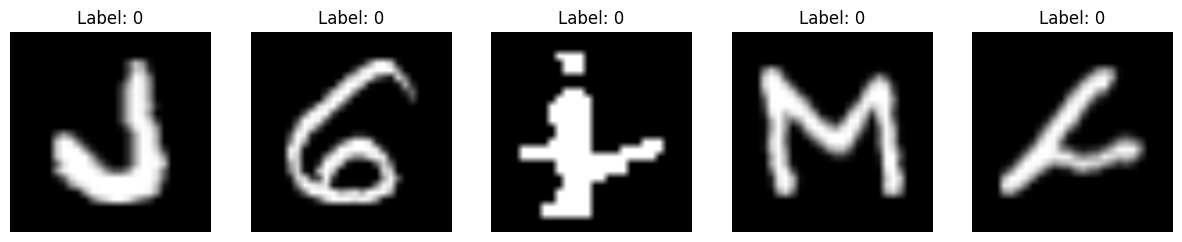

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to visualize images from a DataLoader
def visualize(loader, num_samples=5):
    # Iterate through the DataLoader to get a batch of data
    for batch_idx, (images, labels) in enumerate(loader):
        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
        plt.show()
        break  # Stop after displaying the first batch

# Visualize samples from the training loader
print("Training Samples:")
visualize(train_loader)

# Visualize samples from the validation loader
print("Validation Samples:")
visualize(val_loader)

print("Testing Samples:")
visualize(test_loader)

# MobileNet V3 Small

In [11]:
model = models.mobilenet_v3_small(pretrained=True)

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
in_features = model.classifier[0].in_features

# Modify the classifier layer to match the number of output classes
model.classifier = nn.Sequential(
    nn.Linear(in_features, num_classes),
    nn.Softmax(dim=1)
)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [14]:
model = model.to(device)

# Optimizer and LR

In [15]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
num_epochs = 5
desired_training_accuracy = 99.999
early_stopping_threshold = 3
early_stopping_counter = 0
best_val_loss = float('inf')

In [17]:
# Lists to store training and validation metrics for plotting curves
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

In [18]:
import time

start_time = time.time()

In [19]:
from sklearn.model_selection import KFold

# Assume `dataset` is your PyTorch dataset
num_folds = 5
# Assuming train_dataset is your dataset
X = np.arange(len(train_dataset))  # Placeholder, you will index the dataset with this
y = np.array([label for _, label in train_dataset])  # Extract labels from the dataset

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross-Validation


# Training The Model

kf.split(x,y) => Splits the dataset into number of folds parts 
The loop iterates over the  number of folds and each fold should be used as validation once 

SubsetRandomSampler => Samples training/validation data randomly 
best_acc => stores the best validation accuracy for each fold

model.train()=> set to train mode 
skip invalid batches (labels -1)
torch.max(outputs, 1)  => Finds predicted class 
model.eval()=> set evaluation Mode 









In [20]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{kf.n_splits}")

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler   = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_sampler
    )
    val_loader   = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=val_sampler
    )

    best_acc = 0.0                             # best accuracy for this fold

    fold_train_losses, fold_train_accuracies = [], []
    fold_val_losses,   fold_val_accuracies   = [], []

    for epoch in range(num_epochs):
        # ─── Training ──────────────────────────────────────────────
        model.train()
        running_loss   = 0.0
        correct_train  = 0
        total_train    = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if -1 in labels:
                continue  # skip dummy-label batch

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted_train = torch.max(outputs.data, 1)
            total_train   += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            if i % 100 == 99:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f"Batch {i + 1}/{len(train_loader)}, "
                    f"Training Loss: {running_loss / (i + 1):.4f}, "
                    f"Training Accuracy: {100 * correct_train / total_train:.2f}%"
                )

        training_accuracy = correct_train / total_train
        fold_train_losses.append(running_loss / len(train_loader))
        fold_train_accuracies.append(training_accuracy)

        # ─── Validation ───────────────────────────────────────────
        model.eval()
        val_running_loss = 0.0
        correct_val      = 0
        total_val        = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                val_running_loss += v_loss.item()
                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val  += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        validation_accuracy = correct_val / total_val
        validation_loss     = val_running_loss / len(val_loader)

        fold_val_losses.append(validation_loss)
        fold_val_accuracies.append(validation_accuracy)

        print(
            f"Validation Accuracy after epoch {epoch + 1}/{num_epochs}: "
            f"{100 * validation_accuracy:.2f}%"
        )

        # per-fold best
        if validation_accuracy > best_acc:
            best_acc = validation_accuracy
            torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pth")

        # global best
        if validation_accuracy > best_val_acc_glob:
            best_val_acc_glob = validation_accuracy
            torch.save(model.state_dict(), CKPT_PATH)
            print(
                f"📌 New global best (val_acc={best_val_acc_glob:.4f}), "
                f"saved to {CKPT_PATH}"
            )

        scheduler.step(validation_loss)

    # aggregate metrics across folds
    train_losses    .extend(fold_train_losses)
    train_accuracies.extend(fold_train_accuracies)
    val_losses       .extend(fold_val_losses)
    val_accuracies   .extend(fold_val_accuracies)
    print(f"Best validation accuracy for fold {fold + 1}: {best_acc:.4f}")

Fold 1/5
Epoch 1/5, Batch 100/3445, Training Loss: 0.5161, Training Accuracy: 83.06%
Epoch 1/5, Batch 200/3445, Training Loss: 0.4576, Training Accuracy: 87.91%
Epoch 1/5, Batch 300/3445, Training Loss: 0.4315, Training Accuracy: 89.94%
Epoch 1/5, Batch 400/3445, Training Loss: 0.4169, Training Accuracy: 90.98%
Epoch 1/5, Batch 500/3445, Training Loss: 0.4038, Training Accuracy: 92.03%
Epoch 1/5, Batch 600/3445, Training Loss: 0.3950, Training Accuracy: 92.71%
Epoch 1/5, Batch 700/3445, Training Loss: 0.3873, Training Accuracy: 93.42%
Epoch 1/5, Batch 800/3445, Training Loss: 0.3808, Training Accuracy: 93.98%
Epoch 1/5, Batch 900/3445, Training Loss: 0.3762, Training Accuracy: 94.38%
Epoch 1/5, Batch 1000/3445, Training Loss: 0.3720, Training Accuracy: 94.76%
Epoch 1/5, Batch 1100/3445, Training Loss: 0.3682, Training Accuracy: 95.09%
Epoch 1/5, Batch 1200/3445, Training Loss: 0.3648, Training Accuracy: 95.41%
Epoch 1/5, Batch 1300/3445, Training Loss: 0.3618, Training Accuracy: 95.66%

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/5, Batch 100/3445, Training Loss: 0.3230, Training Accuracy: 99.06%
Epoch 2/5, Batch 200/3445, Training Loss: 0.3209, Training Accuracy: 99.25%
Epoch 2/5, Batch 300/3445, Training Loss: 0.3200, Training Accuracy: 99.38%
Epoch 2/5, Batch 400/3445, Training Loss: 0.3200, Training Accuracy: 99.36%
Epoch 2/5, Batch 500/3445, Training Loss: 0.3203, Training Accuracy: 99.34%
Epoch 2/5, Batch 600/3445, Training Loss: 0.3204, Training Accuracy: 99.31%
Epoch 2/5, Batch 700/3445, Training Loss: 0.3204, Training Accuracy: 99.31%
Epoch 2/5, Batch 800/3445, Training Loss: 0.3206, Training Accuracy: 99.30%
Epoch 2/5, Batch 900/3445, Training Loss: 0.3202, Training Accuracy: 99.33%
Epoch 2/5, Batch 1000/3445, Training Loss: 0.3201, Training Accuracy: 99.34%
Epoch 2/5, Batch 1100/3445, Training Loss: 0.3200, Training Accuracy: 99.36%
Epoch 2/5, Batch 1200/3445, Training Loss: 0.3201, Training Accuracy: 99.34%
Epoch 2/5, Batch 1300/3445, Training Loss: 0.3200, Training Accuracy: 99.35%
Epoch 2/

# Training Time

In [21]:
end_time = time.time()

duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60

print("Training duration: {:.2f} minutes".format(duration_minutes))

Training duration: 98.91 minutes


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Best Model Measures (Test_Acc,Precision,..)

In [23]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for best model checkpoint path and best F1 score
best_f1_score = float('-inf')
ckpt_path = "D:\Ezz\Graduation Project\FinetunedModel2_checkpoint.pth"  # Path to save the best model checkpoint

# Function to evaluate the model and calculate metrics
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = correct / total

    return precision, recall, f1, accuracy

# === Training Loop or After Model Training ===

# Evaluate current model on validation set
val_precision, val_recall, val_f1, val_accuracy = evaluate_model(model, val_loader)
print(f'Validation Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}, Accuracy: {val_accuracy}')

# If current model is best so far, save it
if val_f1 > best_f1_score:
    best_f1_score = val_f1
    best_model=model
    torch.save(model.state_dict(), ckpt_path)
    print(f"Best model saved to {ckpt_path} with F1-score: {best_f1_score}")


Validation Precision: 0.9993354221692956, Recall: 0.9993481554710777, F1: 0.9993417834343926, Accuracy: 0.9993467847292785
Best model saved to D:\Ezz\Graduation Project\FinetunedModel2_checkpoint.pth with F1-score: 0.9993417834343926


In [24]:
# Set the model to evaluation mode
best_model.eval()
correct = 0
total = 0

In [25]:
# Initialize lists to store predictions and true labels
all_labels = []
all_predictions = []

In [26]:
# Disable gradient computation for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels for metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

In [27]:
# Calculate and print the test accuracy
test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

# Compute precision, recall, f1-score and confusion matrix
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

Test Accuracy: 99.77937761263354%


In [28]:
# Print the metrics
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Precision: 99.78%
Recall: 99.78%
F1 Score: 99.78%


# Confusion Matrix

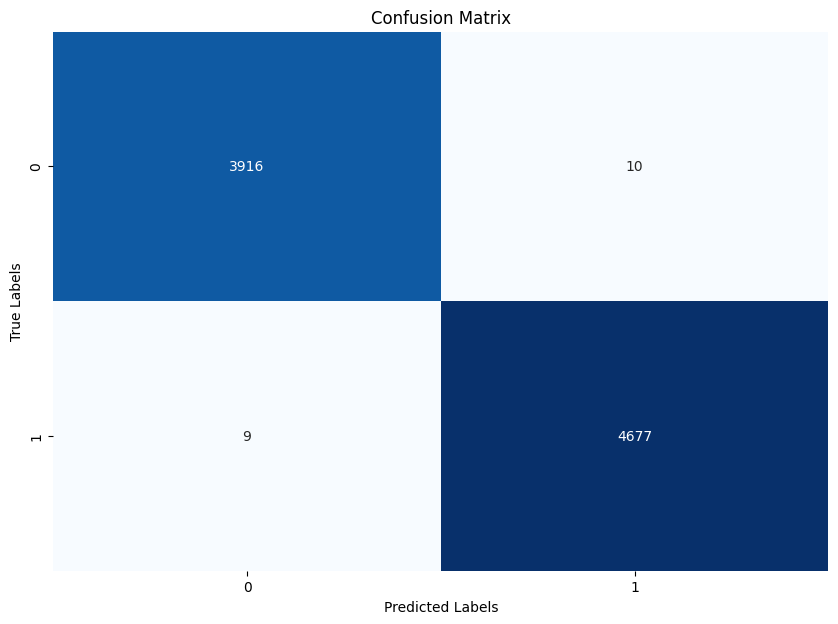

In [29]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Explainable AI

In [30]:
pip install torchcam

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [31]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchvision import models
import numpy as np

In [32]:
# Define the Grad-CAM extractor
cam_extractor = GradCAM(model, target_layer='layer.12')  


ValueError: Unable to find all submodules ['layer.12'] in the model

In [ ]:
# Function to denormalize the image for plotting
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    img = img * std + mean
    return img.clamp(0, 1)

In [ ]:
# Iterate over the test set
for i, (inputs, labels) in enumerate(test_loader):
    # Move the inputs and labels to the same device as the model
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass (do not use torch.no_grad() here, since Grad-CAM needs gradients)
    outputs = best_model(inputs)

    # Get the predicted class (index [0] extracts the value from the tensor)
    predicted = outputs.argmax(dim=1)[0].item()

    # Extract the CAM for the predicted class
    activation_map = cam_extractor(predicted, outputs)

    # Average the activation map across the channel dimension to get a 2D heatmap
    heatmap = activation_map[0].mean(dim=0).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 5))

    # Original image
    ax1 = plt.subplot(1, 3, 1)
    img = denormalize(inputs[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()  # Move the tensor back to CPU for plotting
    ax1.imshow(img)
    ax1.set_title(f'True: {test_dataset.classes[labels[0].item()]}')  # Extract the scalar value from labels
    ax1.axis('off')

    # Heatmap
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(heatmap, cmap='jet')  # Display the 2D heatmap
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    # Overlay the heatmap on the image
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay with transparency
    ax3.set_title(f'Predicted: {test_dataset.classes[predicted]}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Stop after the first example for demonstration; remove this line to iterate over all
    if i == 0:
        break